# SiamAES: Siamese Networks for Automated Essay Scoring
Author: Sam Kadaba, Abel John




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install transformers
!pip install datasets
!pip install kmeans-pytorch
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 26.3 MB/s eta 0:00:0

In [ ]:
from collections import defaultdict, Counter
import json

from matplotlib import pyplot as plt
import pandas as pd
import torch
import math
import pickle
import itertools

from transformers import AutoTokenizer, DistilBertTokenizer, DistilBertModel, DistilBertConfig
import torch.nn as nn
from datasets import load_dataset, DatasetDict, Dataset
from torch.utils.data import DataLoader

from transformers import AdamW, get_linear_schedule_with_warmup
from transformers.modeling_outputs import TokenClassifierOutput
from tqdm.notebook import tqdm
import random
from random import randint

import nltk
nltk.download('all')
from nltk.corpus import wordnet as wn
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

## Utility Functions ##

In [ ]:

def normalize_scores(dataset, num_classes, prompt):
  if(num_classes != None):
    s_qcut, percentiles = pd.qcut(dataset[prompt][:]['score'], q=num_classes, duplicates='drop', retbins=True)
    num_classes = len(percentiles)
    def normalize(example):
      flag = False;
      for index in range(len(percentiles)-1):
        if(example["score"] >= percentiles[index] and example["score"] < percentiles[index+1]):
          example["score"] = index
          flag=True;
      if(not flag):
        example["score"] = num_classes - 1;
      return example
    dataset = dataset.map(normalize)
  else:
    num_classes = max(dataset[prompt][:]["score"])
  return dataset, num_classes;

def select_samples(dataset, prompt, num_classes, neach):
  map_indexes = defaultdict(list);
  for i in range(len(dataset[prompt])):
    score = dataset[prompt][i]['score']
    # print(scores)
    map_indexes[score].append(i);
  return map_indexes;

def modify(text, threshold=1.0):
  words = nltk.word_tokenize(text);
  tagged = nltk.pos_tag(words)
  output = ""
  ps = PorterStemmer()
  map={'NNS':'n', 'NNPS':'n', 'NNP':'n', 'NN':'n', 'JJ':'a', 'JJR':'a', 
      'JJS':'a', 'RB':'r', 'RBR':'r', 'RBS':'r', 'WP':'r',
      'VB':'v', 'VBD':'v', 'VBG':'v', 'VBN':'v', 'VBP':'v', 'VBZ':'v'} 

  for i in range(0,len(words)):
      replacements = []
      epsilon = abs(np.random.randn())
      for syn in wn.synsets(words[i]):
          if tagged[i][1] == 'NNP' or tagged[i][1] == 'NNS' or tagged[i][1] == "NN" or tagged[i][1] == 'DT':
              break          
          word_type = tagged[i][1][0].lower(); 
          if syn.name().find("."+word_type+"."):
              if(tagged[i][1] in map.keys()):
                r = WordNetLemmatizer().lemmatize(syn.name()[0:syn.name().find(".")], map[tagged[i][1]])
              else:
                r = words[i]
              replacements.append(r)
      if len(replacements) > 0:
          replacement = replacements[randint(0,len(replacements)-1)] if epsilon < threshold else words[i]
          output = output + " " + replacement
      else:
          output = output + " " + words[i] if epsilon > threshold else output + " "
  return output

def augment(dataset, prompt, indexes, n_augment):
  last = len(dataset[prompt]);
  for i in range(len(indexes)):
    for j in range(n_augment):
      new_item = {'essay':modify(dataset[prompt][i]['essay']), 'score':dataset[prompt][indexes[i]]['score']};
      dataset[prompt] = dataset[prompt].add_item(new_item);
      indexes.append(last);
      last += 1;
  return dataset, indexes

def train_test_split(l1, l2):
  ind = [0] + list(itertools.accumulate(l2))
  return  [l1[ind[i]:ind[i+1]] for i in range(len(ind)-1)]

def load_and_filter(prompt, num_classes=None, neach=2, n_augment=10, split=[10, 10]):
  dataset = load_dataset("Ericwang/ASAP")
  num_classes = num_classes if num_classes != None else None
  dataset, num_classes = normalize_scores(dataset, num_classes, prompt);
  map_indexes = select_samples(dataset, prompt, num_classes, neach);

  desired = [neach, split[0], split[1]];
  train = [];
  val = [];
  test = [];
  for score in range(num_classes):
    splits = train_test_split(map_indexes[score], desired);
    train += splits[0];
    val += splits[1];
    test += splits[2];

  dataset, indexes = augment(dataset, prompt, train, n_augment);
  random.shuffle(train); random.shuffle(val); random.shuffle(test);
  dataset = DatasetDict(
      train=dataset[prompt].select(indexes),
      val=dataset[prompt].select(val),
      test=dataset[prompt].select(test),
  )
  return dataset, num_classes

In [ ]:
def tokenize(dataset, batch_size):
  tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
  tokenized_dataset = dataset.map(
      lambda example: tokenizer(example['essay'], padding='max_length', truncation=True),
      batched=True,
      batch_size=batch_size
  )
  essays = tokenized_dataset['test']['essay'];
  tokenized_dataset = tokenized_dataset.remove_columns(["essay"])
  tokenized_dataset = tokenized_dataset.rename_column("score", "labels")
  tokenized_dataset.set_format("torch")

  train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, num_workers=4, pin_memory=True);
  eval_dataloader = DataLoader(tokenized_dataset['val'], batch_size=batch_size, num_workers=4, pin_memory=True);
  test_dataloader = DataLoader(tokenized_dataset['test'], batch_size=1)

  return train_dataloader, eval_dataloader, test_dataloader, essays

In [ ]:
def gen_data(prompt, num_classes, n_each, n_augment, flag, split):
  counts = defaultdict(int);
  dataset, num_classes = load_and_filter(prompt, num_classes, n_each, n_augment, split);
  batch_size = 1
  train_dataloader, eval_dataloader, test_dataloader, essays = tokenize(dataset, batch_size);

  count_train = 0
  batches_train = []
  for batch_i, batch in enumerate(train_dataloader):
    count_train += 1
    batches_train.append(batch);
  print(count_train)

  ct_eval = 0
  batches_eval = [];
  for batch_i, batch in enumerate(eval_dataloader):
    ct_eval += 1
    batches_eval.append(batch);
  print(ct_eval)

  ct_test = 0
  batches_test = [];
  for batch_i, batch in enumerate(test_dataloader):
    ct_test += 1
    batches_test.append(batch)
  print(ct_test)
  if(flag):
    train_dataloader = list(itertools.combinations(batches_train, 2)); 
    eval_dataloader = list(itertools.combinations(batches_eval, 2)); 

  for batch in batches_test:
    counts[batch['labels'].item()]+=1
  return num_classes, counts, train_dataloader, eval_dataloader, test_dataloader, essays

## Baseline ##

In [ ]:
class BaselineModel(torch.nn.Module):
  def __init__(self,num_classes): 
    super(BaselineModel,self).__init__() 
    self.num_labels = num_classes


    self.dropout = nn.Dropout(0.2) 

    # Configure DistilBERT's initialization
    config = DistilBertConfig(output_hidden_states=True, dropout=0.2)

    self.model = DistilBertModel.from_pretrained("distilbert-base-uncased", config=config)
    for name, param in list(self.model.named_parameters())[:-2]: 
        param.requires_grad = False
    self.classifier = nn.Linear(768, num_classes) # load and initialize weights

  def forward(self, input_ids=None, attention_mask=None, labels=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    #Add custom layers
    sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state
    embed = sequence_output[:,0,:].view(-1,768)
    logits = self.classifier(embed) # calculate losses
    
    target = torch.nn.functional.one_hot(labels, num_classes=self.num_labels).double()
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), target)

    return (TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions), embed, target)

In [ ]:
def train_baseline(model, train_dataloader, eval_dataloader, num_epochs, num_classes, dirpath):
  num_training_steps = num_epochs * len(train_dataloader)
  optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
  lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

  best_val_loss = float("inf")
  progress_bar = tqdm(range(num_training_steps))

  train_loss_history = [];
  val_loss_history = [];

  for epoch in range(num_epochs):
      # training
      model.train()
      train_loss = 0;
      for batch_i, batch in enumerate(train_dataloader):
          batch = {k: v.to(device) for k, v in batch.items()}
          # batch = ([text1, text2], [0, 1])
          output = model(**batch)
          output = output[0];
          
          optimizer.zero_grad()
          train_loss += output.loss;
          output.loss.backward()
          optimizer.step()
          lr_scheduler.step()
          progress_bar.update(1)

      avg_train_loss = train_loss/len(train_dataloader);
      # validation
      model.eval()
      val_loss = 0;
      for batch_i, batch in enumerate(eval_dataloader):
          batch = {k: v.to(device) for k, v in batch.items()}
          with torch.no_grad():
              output = model(**batch)
              output = output[0];
          val_loss += output.loss
      
      avg_val_loss = val_loss / len(eval_dataloader)
      train_loss_history.append(avg_train_loss.cpu().item());
      val_loss_history.append(avg_val_loss.cpu().item());
      print(f"Epoch {epoch+1}" + " | " + f"Training loss: {avg_train_loss}" + " | " + f"Validation loss: {avg_val_loss}")
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
  return model, train_loss_history, val_loss_history

## Siamese Network ##

In [ ]:
class SiameseNetwork(nn.Module):

    def __init__(self, num_labels):
        super(SiameseNetwork, self).__init__()
        self.num_labels = num_labels;
        self.dropout = nn.Dropout(0.1) 
        self.LSTM = nn.LSTM(768, 768, bias=True, bidirectional=True)
        self.LSTM.train()
        # Configure DistilBERT's initialization
        config = DistilBertConfig(output_hidden_states=True, dropout=0.1)

        self.model = model = DistilBertModel.from_pretrained("distilbert-base-uncased", config=config)
        for name, param in list(self.model.named_parameters())[3:-3]: 
            param.requires_grad = False
        
        self.classifier = nn.Linear(768, num_labels) # load and initialize weights
        torch.nn.init.xavier_uniform(self.classifier.weight)

    def forward_one(self, input_ids=None, attention_mask=None, labels=None):
        token_embeds = self.model.get_input_embeddings().weight[input_ids].detach().clone()
        token_embeds.requires_grad = True;
        outputs = self.model(inputs_embeds=token_embeds, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state
        # print(sequence_output.size())
        encoder_input = sequence_output[0,:,:].squeeze(0).view(-1,768)
        # print("LSTM_input:", encoder_input.size())
        LSTM_values = self.LSTM(encoder_input)
        # embedding corresponding to final hidden state
        embed = LSTM_values[1][0]
        # average beginning and end vectors
        embed = (torch.add(embed[0,:], embed[1,:]) / 2).unsqueeze(0)
        # print("embedding size:", embed.size())
        return LSTM_values[0], embed, token_embeds


    def forward(self, x1, x2):

        outputs_x1, out_x1, token_embeds_x1 = self.forward_one(**x1)
        logits_x1 = self.classifier(out_x1)
        target_x1 = torch.nn.functional.one_hot(x1['labels'], num_classes=self.num_labels).double()
        args_x1 = (logits_x1, target_x1, outputs_x1, token_embeds_x1)

        if(x2 is not None):
          outputs_x2, out_x2, token_embeds_x2 = self.forward_one(**x2)
          logits_x2 = self.classifier(out_x2);
          target_x2 = torch.nn.functional.one_hot(x2['labels'], num_classes=self.num_labels).double()
          args_x2 = (logits_x2, target_x2, outputs_x2, token_embeds_x2)
          return out_x1, out_x2, args_x1, args_x2
        else:
          # grad = torch.autograd.grad(logits_x1[0][0], token_embeds_x1);
          args_x1 = (logits_x1, target_x1, outputs_x1)
          return out_x1, args_x1
                                
                              
class CrossEntropyLoss(torch.nn.Module):
  def __init__(self, num_labels):
    super(CrossEntropyLoss, self).__init__()  # pre 3.3 syntax
    self.num_labels = num_labels;
    self.softmax = nn.Softmax(dim=1)
    
  def forward(self, x):
    loss_fct = nn.CrossEntropyLoss();
    logits = x[0]; target = x[1]; outputs = x[2];
    # print("target_x1", target.size())
    # print("logits:", logits.size())
    #print(self.softmax(logits), target)
    loss = loss_fct(logits, target)
    return loss 

class ContrastiveLoss(torch.nn.Module):
  def __init__(self, m=1):
    super(ContrastiveLoss, self).__init__()  # pre 3.3 syntax
    self.m = m  # margin or radius

  def forward(self, y1, y2, flag):
    # flag = 1 means y1 and y2 are supposed to be same
    # flag = 0 means y1 and y2 are supposed to be different
    #(torch.norm(y1, 1) + torch.norm(y2, 1)) / 2
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    euc_dist = cos(y1, y2)
    loss = torch.mean(flag * torch.pow(euc_dist, 2) + (1-flag) * torch.pow(torch.clamp(self.m - euc_dist, min=0.0), 2))
    return loss 
        

In [ ]:
import os 
import shutil 

def train_siamese(model, train_dataloader, eval_dataloader, num_epochs, num_classes, dirpath):
  loss_func = ContrastiveLoss()
  loss_func_classification = CrossEntropyLoss(num_classes)

  num_training_steps = num_epochs * len(train_dataloader)
  optimizer = AdamW(model.parameters(), lr=5e-3, weight_decay=0.1)
  lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

  best_val_loss = float("inf")
  progress_bar = tqdm(range(num_training_steps))

  train_loss_history = [];
  val_loss_history = [];
  alpha, beta, gamma = 1, 1, 1;
  for epoch in range(num_epochs):
      # training
      model.train()
      train_loss = 0;
      for (sample1, sample2) in train_dataloader:
          sample1 = {k: v.to(device) for k, v in sample1.items()}
          sample2 = {k: v.to(device) for k, v in sample2.items()}
          # batch = ([text1, text2], [0, 1])
          out_x1, out_x2, update_x1, update_x2 = model(sample1, sample2)
          
          optimizer.zero_grad()
          flag = sample1['labels'] == sample2['labels']; flag = flag.cpu().item();
          # print(out_x1, " p3n1s ", out_x2)
          loss_val = gamma*loss_func(out_x1, out_x2, flag)
          loss_val.backward(retain_graph=True)         # compute grads
          optimizer.step()            # update weights
          
          x1_classification_val = alpha*loss_func_classification(update_x1);
          x1_classification_val.backward(retain_graph=True)         # compute grads
          optimizer.step()            # update weights

          x2_classification_val = beta*loss_func_classification(update_x2);
          x2_classification_val.backward()         # compute grads
          optimizer.step()  

          train_loss += x1_classification_val.item() + x2_classification_val.item() + loss_val.item()
    
          lr_scheduler.step()
          progress_bar.update(1)

      avg_train_loss = train_loss/len(train_dataloader);

      # validation
      model.eval()
      val_loss = 0;
      for (sample1, sample2) in eval_dataloader:
          sample1 = {k: v.to(device) for k, v in sample1.items()}
          sample2 = {k: v.to(device) for k, v in sample2.items()}
          flag = sample1['labels'] == sample2['labels']; flag = flag.cpu().item()
          with torch.no_grad():
                out_x1, out_x2, update_x1, update_x2 = model(sample1, sample2)
                x1_classification_val = loss_func_classification(update_x1);
                x2_classification_val = loss_func_classification(update_x2);
                loss_val = loss_func(out_x1, out_x2, flag) 
          val_loss +=  x1_classification_val.item() + x2_classification_val.item() +loss_val.item();

      avg_val_loss = val_loss / len(eval_dataloader)
      train_loss_history.append(avg_train_loss);
      val_loss_history.append(avg_val_loss);
      print(f"Epoch {epoch+1}" + " | " + f"Training loss: {avg_train_loss}" + " | " + f"Validation loss: {avg_val_loss}")
      if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
      best_val_loss = avg_val_loss
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': best_val_loss,
          },
          f"{dirpath}/epoch_{epoch}.pt"
          )
  return model, train_loss_history, val_loss_history
        

## Evaluation ##

In [ ]:
## Evaluation ##
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import OPTICS

def run_eval(model, test_dataloader, flag):
    # on test set ##
    model.eval()
    predictions_test = [];
    labels_test = [];
    E = []
    softmax = nn.Softmax(dim=1)
    # grads = [];
    for batch_i, batch in enumerate(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
    
        if(flag):
          embed_x1, update_x1= model(batch, None)
          logits = update_x1[0]; target = update_x1[1];
          # grad = update_x1[3][0].detach().cpu().numpy()
          # grads.append(grad)
        else:
          outputs = model(**batch); 
          logits = outputs[0]['logits']; embed_x1 = outputs[1]; target = outputs[2];
        
        pred = np.argmax(softmax(logits.detach().cpu()))
        truth = np.argmax(target.detach().cpu())
        predictions_test.append(pred);
        labels_test.append(truth);
        E.append(embed_x1)

    E = torch.stack(E, dim=0);
    E = E.view(len(test_dataloader), -1).detach().cpu()

    pca = decomposition.PCA(n_components=2)
    x = torch.Tensor(pca.fit_transform(E))
    db = OPTICS().fit(x)
    clusters=x;
    return labels_test, predictions_test, clusters, db
    # , grads

def get_accuracy(actual, predicted):
    correct = 0;
    for i in range(len(actual)):
      print(predicted[i], actual[i])
      if(predicted[i] == actual[i]):
        correct += 1;
    return correct/len(actual);

def get_f1(actual, predicted, num_classes):
  f1s = [];
  for i in range(num_classes):
    tp = 0;
    fp = 0;
    fn = 0;
    for j in range(len(predicted)):
      if(predicted[j] == actual[j] and actual[j] == i):
        tp += 1;
      if(predicted[j] == i and actual[j] != i):
        fp += 1;
      if(predicted[j] != i and actual[j] == i):
        fn += 1;
    precision = tp / (tp + fp + 1)
    recall = tp / (tp + fn + 1)
    f1 = 2*precision*recall / (precision+recall+1)
    f1s.append(f1)
  return f1s;

def get_confusion(actual, predicted):
    return metrics.confusion_matrix(actual, predicted)


def run_summary(model, test_dataloader, num_classes, flag):

   actual, predicted, clusters, db = run_eval(model, test_dataloader, flag)
   # , grads
   accuracy = get_accuracy(actual, predicted);
   f1 = get_f1(actual, predicted, num_classes);
   confusion = get_confusion(actual, predicted)

   return accuracy, f1, confusion, clusters, db
   #, grads

def generate_figures(training_history, validation_history, confusion_matrix, clusters, db):
    x = range(len(training_history))
    fig1 = plt.figure(1);
    plt.plot(x, training_history);
    plt.xlabel("Epoch #")
    plt.ylabel("Cross Entropy Loss");
    plt.title("Training History");
    
    x = range(len(validation_history))
    fig2 = plt.figure(2);
    plt.plot(x, validation_history);
    plt.xlabel("Epoch #")
    plt.ylabel("Cross Entropy Loss");
    plt.title("Validation History");

    fig3 = plt.figure(3)
    ax = fig3.add_subplot(111)
    cax = ax.matshow(confusion_matrix, interpolation='nearest')
    fig3.colorbar(cax)

    fig4 = plt.figure(4);
    plt.figure(figsize=(4, 3), dpi=160)
    plt.scatter(clusters[:, 0], clusters[:, 1], c=db.labels_, cmap='cool')
    plt.axis([-1, 1, -1, 1])
    plt.tight_layout()
    plt.show()
    
    return fig1, fig2, fig3, fig4

## Run Main ##

In [ ]:
# Generate data #
prompt = '1';
num_classes = 2;
n_augment = 2;
n_each = 3;
flag = 1;
splits = [n_each, 50]
num_classes, counts, train_dataloader, eval_dataloader, test_dataloader, essays = gen_data(prompt, num_classes, n_each, n_augment, flag, splits)
print("")
print("Target number of classes =", num_classes);
print(counts)
print("")

## Define and load pretrained model ##
model = SiameseNetwork(num_classes)
model = model.to(device)

## Train model ##
num_epochs = 10;
dirpath = '/content/'
model, train_loss_history, val_loss_history = train_siamese(model, train_dataloader, eval_dataloader, num_epochs, num_classes, dirpath)



  0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/141 [00:00<?, ? examples/s]

27
9
141

Target number of classes = 3
defaultdict(<class 'int'>, {1: 50, 2: 41, 0: 50})



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-8-1594c21f67c7>:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.classifier.weight)
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: 

  0%|          | 0/3510 [00:00<?, ?it/s]

Epoch 1 | Training loss: 2.9371222550012215 | Validation loss: 2.275932951024365
Saving checkpoint!
Epoch 2 | Training loss: 2.4926326219475 | Validation loss: 2.5677218380419324
Epoch 3 | Training loss: 2.374981054354106 | Validation loss: 2.3851782470366913
Saving checkpoint!
Epoch 4 | Training loss: 2.085548157569945 | Validation loss: 2.003203092325329
Saving checkpoint!
Epoch 5 | Training loss: 2.6589917849346656 | Validation loss: 2.5764875787867205
Epoch 6 | Training loss: 2.1236404132084825 | Validation loss: 2.9019913931530983
Epoch 7 | Training loss: 1.7877176445314409 | Validation loss: 3.835210921110929
Epoch 8 | Training loss: 1.203875294009201 | Validation loss: 3.6834688970299903
Saving checkpoint!
Epoch 9 | Training loss: 0.9034298848486053 | Validation loss: 3.6615415932112745
Saving checkpoint!
Epoch 10 | Training loss: 0.514035757321843 | Validation loss: 3.8927627254267287


tensor(2) tensor(2)
tensor(2) tensor(2)
tensor(1) tensor(0)
tensor(2) tensor(2)
tensor(2) tensor(0)
tensor(1) tensor(2)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(1)
tensor(2) tensor(1)
tensor(1) tensor(1)
tensor(2) tensor(2)
tensor(0) tensor(0)
tensor(2) tensor(2)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(1) tensor(1)
tensor(2) tensor(1)
tensor(2) tensor(2)
tensor(0) tensor(1)
tensor(0) tensor(0)
tensor(2) tensor(0)
tensor(2) tensor(1)
tensor(1) tensor(2)
tensor(1) tensor(1)
tensor(0) tensor(0)
tensor(1) tensor(0)
tensor(0) tensor(1)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(1)
tensor(1) tensor(2)
tensor(2) tensor(2)
tensor(2) tensor(1)
tensor(0) tensor(0)
tensor(2) tensor(2)
tensor(0) tensor(0)
tensor(1) tensor(1)
tensor(2) tensor(2)
tensor(1) tensor(1)
tensor(1) tensor(0)
tensor(2) tensor(2)
tensor(1) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(2) tensor(2)
tensor(0) tensor(1)
tensor(0) tensor(0)
tensor(0) tensor(1)
tensor(0) tensor(1)


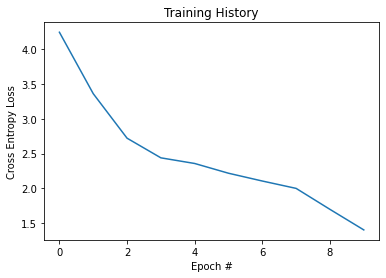

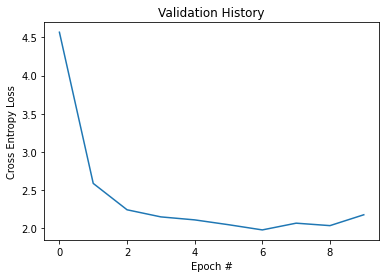

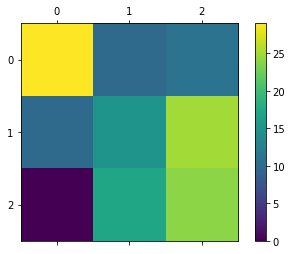

<Figure size 432x288 with 0 Axes>

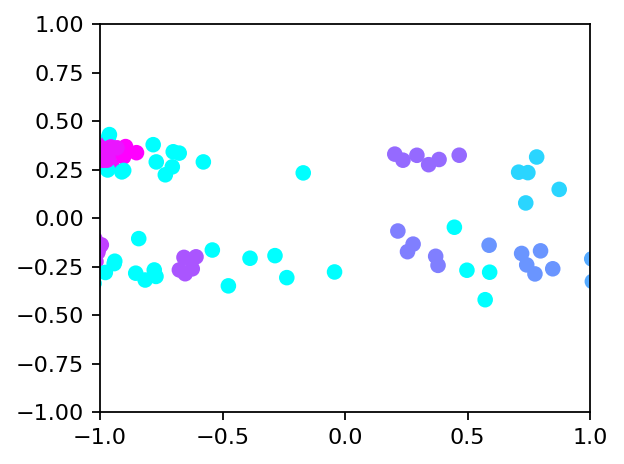

In [ ]:
## Evaluate model ##
accuracy, f1, confusion, clusters, db = run_summary(model, test_dataloader, num_classes, flag);
# , grads
print("Accuracy = " + str(accuracy) + " | f1 = " + str(f1));
train_fig, validation_fig, confusion_fig, clsuters_fig = generate_figures(train_loss_history, val_loss_history, confusion, clusters, db)

## Junk ##

In [ ]:
## Evaluation ##

from jax._src.traceback_util import path_starts_with
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy
from sklearn import metrics

def eval_metrics(filepath):
   exp_meta = open(filepath,'rb')
   exp_meta = pickle.load(exp_meta)
   x = range(exp_meta['training_params']['num_epochs']);
   training_history = [i for i in exp_meta['results']['training']];
   validation_history = [i.cpu().item() for i in exp_meta['results']['validation']];
   actual = exp_meta['results']['testing']['labels'];
   predicted = exp_meta['results']['testing']['predictions'];

   correct = 0;
   for i in range(len(predicted)):
     if(predicted[i] == actual[i]):
      correct += 1;
   accuracy = correct/len(predicted);
   num_classes = exp_meta['training_params']['num_classes'];

   confusion_matrix = metrics.confusion_matrix(actual, predicted)
   return x, training_history, validation_history, num_classes, confusion_matrix, accuracy, exp_meta['data'];

def generate_figures(args):
  x, training_history, validation_history, num_classes, confusion_matrix, accuracy, data = args;
  fig1 = plt.figure(1);
  plt.plot(x, training_history);
  plt.xlabel("Epoch #")
  plt.ylabel("Cross Entropy Loss");
  plt.title("Training History");
  
  fig2 = plt.figure(2);
  plt.plot(x, validation_history);
  plt.xlabel("Epoch #")
  plt.ylabel("Cross Entropy Loss");
  plt.title("Validation History");

  fig3 = plt.figure(3)
  ax = fig3.add_subplot(111)
  cax = ax.matshow(confusion_matrix, interpolation='nearest')
  fig3.colorbar(cax)
  
  SummaryPage = plt.figure(4, figsize=(11.69,8.27))
  SummaryPage.clf()
  txt = "Accuracy = " + str(accuracy) + " | " + "Number of classes = " + str(num_classes) + "\n";
  txt += "\n" + "Meta data = " + str(data)
  print(txt);
  SummaryPage.text(0.5,0.5,txt, transform=SummaryPage.transFigure, size=16, ha="center")


  def save_multi_image(filename):
    pp = PdfPages(filename)
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

  filename = dirpath + "/p" + prompt + ".siamese.2.pdf"
  save_multi_image(filename)

  return fig1, fig2, fig3, SummaryPage

# main #
filepath = dirpath + '/' + exp_name + '.pickle'
args = eval_metrics(filepath)
fig = generate_figures(args)
plt.show(fig)

In [ ]:
import itertools

def normalize_scores(dataset, num_classes):

  normalized = dict();
  classes = dict();
  for i in range(1, 8):
    max_score = -float('inf')
    min_score = float('inf');
    for j in range(len(dataset[str(i)])):
      sample_score = dataset[str(i)][j]['score'];
      if(sample_score > max_score):
        max_score = sample_score;
      if(sample_score < min_score):
        min_score = sample_score;
    datalist = []
    for k in range(len(dataset[str(i)])):
      if(num_classes is not None):
        new_score = int((dataset[str(i)][k]['score'] - min_score)/(max_score - min_score) * num_classes)
      else:
        new_score = dataset[str(i)][k]['score']
      datalist.append({'essay':dataset[str(i)][k]['essay'], 'score':new_score});
    normalized[str(i)] = datasets.Dataset.from_pandas(pd.DataFrame(data=datalist))
    classes[str(i)] = max_score-min_score + 1 if num_classes is None else num_classes + 1
  return normalized, classes 

dataset = load_dataset("Ericwang/ASAP")
num_classes = 5
dataset, classes = normalize_scores(dataset, num_classes);
prompt = '1'
num_classes = classes[prompt]

def select_samples(dataset, prompt, neach):
  seen = []
  indexes = [];
  for i in range(len(dataset[prompt])):
    score = dataset[prompt][i]['score'];
    if(seen.count(score) <= neach):
      indexes.append(i);
    seen.append(score)
  return indexes;

neach = 5;
indexes = select_samples(dataset, prompt, neach);
sz = len(dataset[prompt]);
train_sz, val_sz, test_sz = len(indexes), math.floor((sz-len(indexes))/2), math.floor((sz-len(indexes))/2)

unobserved = [i for i in range(sz) if i not in indexes]
dataset = DatasetDict(
    train=dataset[prompt].shuffle(seed=1111).select(indexes),
    val=dataset[prompt].shuffle(seed=1111).select(unobserved[0:val_sz]),
    test=dataset[prompt].shuffle(seed=1111).select(unobserved[val_sz:val_sz+test_sz]),
)

In [ ]:
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from random import randint
import nltk.data
from nltk.stem.wordnet import WordNetLemmatizer

# import these modules
from nltk.stem import PorterStemmer
  


In [ ]:
exp_meta = dict();
exp_meta['results'] = {'testing': {'labels':labels_test, "predictions": predictions_test}, 
                    'training':train_loss_history, 'validation':val_loss_history}
exp_meta['data'] = {'prompt':prompt}
exp_meta['training_params'] = {'num_epochs':num_epochs, 'num_classes':num_classes}

with open(dirpath + '/' + exp_name + '.pickle', 'wb') as handle:
    pickle.dump(exp_meta, handle)